# 因子成分选择

In [21]:
from WindPy import w
import pandas as pd
import numpy as np
import os
import shutil
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_white, het_breuschpagan
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.seasonal import STL
from matplotlib.font_manager import FontProperties 
matplotlib.pyplot.rcParams['font.sans-serif']=['simhei']
font_path = '/Users/miaxiaozile/Library/Fonts/SimHei.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['axes.unicode_minus']=False

In [22]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [42]:
start_date = "2008-12-01" # 实际从2010开始，取多余数据是为了数据处理
end_date = "2024-06-30"

In [24]:
# 输入一个字典，其每个指标对应万德代码
# 输出一个含所有指标的表格
def extract_inds(inds):
    df = pd.DataFrame()
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date)
        # 从万德API获取数据
        times = raw.Times
        data = raw.Data[0]
        # 将数据中的时间相与Pandas的日期时间格式对齐
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # 为这一指标创造一个暂时的表格
        temp_df = pd.DataFrame(data, index=times, columns=[ind])
        
        # 将表格合并
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    return df

In [25]:
# 数据滞后
def lag_data(df, periods=1):
    df_lagged = df.shift(periods)
    df_lagged = df_lagged.iloc[periods:]  # 删除第一行(NaN)
    return df_lagged

In [26]:
# X-11 季节性处理
def apply_x11(df, columns, x13as_path='/usr/local/bin/x13as'):
    tempdir = os.path.join(os.getcwd(), 'x13as_temp')
    os.makedirs(tempdir, exist_ok=True)

    df_adjusted = df.copy()
    for column in columns:
        ts = df[column].asfreq('M')
        
        # 处理0或负的数据
        min_value = ts.min()
        shift_value = abs(min_value) + 1 if min_value <= 0 else 0
        ts_shifted = ts + shift_value
        
        try:
            result = sm.tsa.x13_arima_analysis(ts_shifted, x12path=x13as_path, tempdir=tempdir)
            if result is None:
                raise ValueError(f"X-13ARIMA-SEATS returned None for column: {column}")
            
            # 将季调数据调回
            df_adjusted[column] = result.seasadj - shift_value
            
        except Exception as e:
            print(f"Error processing column {column}: {e}")
            
            # 了解错误
            err_file_path = os.path.join(tempdir, 'x13as.err')
            if os.path.exists(err_file_path):
                with open(err_file_path, 'r') as err_file:
                    print(f"Error file content for column {column}:")
                    print(err_file.read())
            continue
    
    # 清理暂时创建的文档
    shutil.rmtree(tempdir)

    return df_adjusted

In [27]:
# STL 季调 - 没有使用
def apply_stl(df, columns, seasonal=4):
    df_adjusted = df.copy()
    for column in columns:
        stl = STL(df[column], seasonal=seasonal)
        result = stl.fit()
        df_adjusted[column] = result.seasonal  # 用季调后的成分取代
    return df_adjusted

In [28]:
# 对数同比差分处理
def logyoy(df, columns):
    df_log_yoy = df.copy()
    for column in columns:
        df_log_yoy[column] = np.log(df[column] / df[column].shift(12)) * 100
    df_log_yoy = df_log_yoy.iloc[12:]  # 删除前12月以防止NaN值
    return df_log_yoy

In [51]:
# 实际因子指标筛选: 对汇率回归以记录 Beta, T-Value, and R-Squared
# 重复1000次并记录以上每项中位数
def regress(indicator_df, forex_df, target_column='美元人民币中间价', n_iterations=1000, min_period_length=24):
    # 建立一个表格以记录回归结果
    forex_df.index = indicator_df.index
    results = []

    for i in range(n_iterations):
        # 放回抽样
        sample_indices = np.random.choice(indicator_df.index, size=len(indicator_df), replace=True)
        sample_growth_df = indicator_df.loc[sample_indices]
        sample_forex_df = forex_df.loc[sample_indices]
        
        # 随机抽取起始与结束日期
        start_idx = np.random.randint(0, len(sample_growth_df) - min_period_length)
        end_idx = start_idx + min_period_length
        
        # 确保时段超过两年
        sample_growth_period = sample_growth_df.iloc[start_idx:end_idx]
        sample_forex_period = sample_forex_df.iloc[start_idx:end_idx]
        
        # 以每一指标进行回归
        for indicator in indicator_df.columns:
            X = sample_growth_period[[indicator]]
            X = sm.add_constant(X)
            y = sample_forex_period[target_column]
            
            model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
            beta = model.params[indicator]
            t_value = model.tvalues[indicator]
            r_squared = model.rsquared
            
            # 添加结果
            results.append({
                'Indicator': indicator,
                'Beta': beta,
                'T-Value': t_value,
                'R-Squared(%)': r_squared * 100  # Convert to percentage
            })
            
    # 将结果转为表格
    growth_results_df = pd.DataFrame(results)

    # 计算中位数
    growth_median_results = growth_results_df.groupby('Indicator').median().reset_index()

    # 添加格式
    growth_median_results['Beta'] = growth_median_results['Beta'].map("{:.2f}".format)
    growth_median_results['T-Value'] = growth_median_results['T-Value'].map("{:.2f}".format)
    growth_median_results['R-Squared(%)'] = growth_median_results['R-Squared(%)'].map("{:.2f}%".format)

    return growth_median_results

In [48]:
# 获取美元人民币中间价数据
fx_data = w.edb("M0000185", "2009-01-01", end_date, Period="M")
# 数据处理
times = fx_data.Times
data = fx_data.Data[0]
times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")

# 建立表格
df_forex = pd.DataFrame(data, index=times, columns=["美元人民币中间价"])
df_forex = logyoy(df_forex, df_forex.columns)
df_forex = df_forex[df_forex.index <= end_date]
df_forex

,美元人民币中间价
2010-01-29,-0.160995
2010-02-26,-0.160998
2010-03-31,-0.140534
2010-04-30,0.019046
2010-05-31,-0.064420
...,...
2024-02-29,2.158669
2024-03-29,3.197878
2024-04-30,2.598808
2024-05-31,0.376298


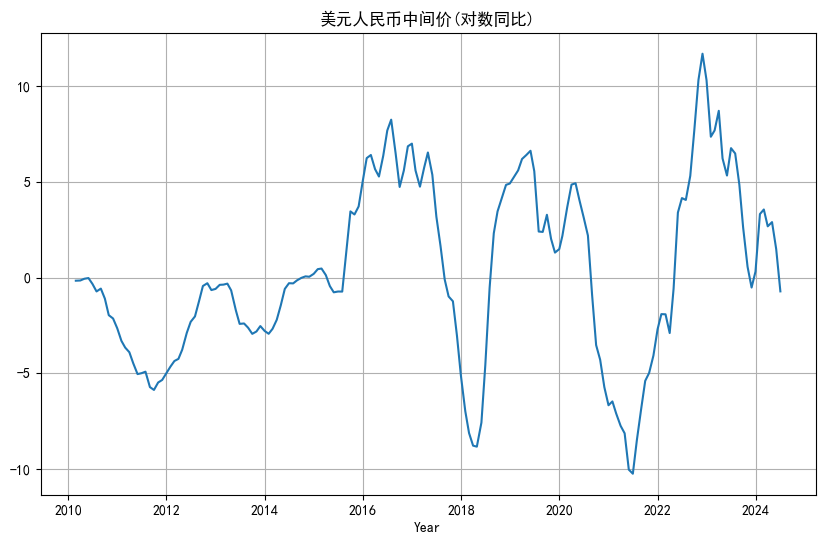

In [31]:
smoothed_fx = df_forex.rolling(window=2).mean()
plt.figure(figsize=(10, 6))
plt.plot(smoothed_fx.index, smoothed_fx[["美元人民币中间价"]])
plt.xlabel('Year')
plt.title('美元人民币中间价(对数同比)')
plt.grid(True)
plt.show()

In [32]:
# 因子合成
def combine_factors(df1, columns_df1, df2=None, columns_df2=None, fx_rate = df_forex['美元人民币中间价']):
    inverse_volatilities = {}
    columns = {}

    # 处理第1个表格中选中的列
    for column in columns_df1:
        series = df1[column]
        correlation = series.corr(fx_rate)
        if correlation < 0:
            series = -series  # 如暴露为负，将这一序列倒过来
        inverse_volatilities[column] = 1 / series.std()
        columns[column] = series

    # 处理第2个表格中选中的列
    if df2 is not None and columns_df2 is not None:
        for column in columns_df2:
            series = df2[column]
            correlation = series.corr(fx_rate)
            if correlation < 0:
                series = -series  # 如暴露为负，将这一序列倒过来
            inverse_volatilities[column] = 1 / series.std()
            columns[column] = series

    total_inverse_volatility = sum(inverse_volatilities.values())

    weights = {key: inv_vol / total_inverse_volatility for key, inv_vol in inverse_volatilities.items()}

    combined_factor = sum(weights[key] * columns[key] for key in columns)

    return combined_factor, weights

In [67]:
# 计算滚动平均值（平滑处理）并绘图的函数
def plot_smoothed_data(category, factor, df, column, window_size=2):
    # 计算滚动平均值（平滑处理）
    smoothed_serie = df[column].rolling(window=window_size).mean()
    smoothed_factor = factor.rolling(window=window_size).mean()

    # 绘图
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_serie.index, smoothed_serie, label=f'{column} (平滑处理)')
    plt.plot(smoothed_factor.index, smoothed_factor, label=f'{category}因子 (平滑处理)')
    plt.xlabel('Year')
    plt.ylabel('% Change')
    plt.title(f'{category}因子 vs. {column}')
    plt.legend()
    plt.grid(True)
    plt.show()

## 增长因子

In [37]:
# 考察中国的增长指标
china_growth_inds = {
    # 生产法
    # 总量指标
    'GDP(%)': 'M0039354',
    '工业增加值(%)': 'M0000545',
    'PMI': 'M0017126',
    'PMI_生产': 'M0017127',
    'PMI_新订单': 'M0017128',
    # 分行业指标
    '发电量(%)': 'S0027013',
    '水泥产量(%)': 'S0027703',
    '粗钢产量(%)': 'S0027375',
    '汽车产量(%)': 'S0027908',
    '铁路货运量(%)': 'S0036034',
    # 支出法 
    # 投资
    '固定资产投资(%)': 'M0000273',
    '房地产投资(%)': 'S0029657',
    '基建投资(%)': 'M5440435',
    '制造业投资(%)': 'M0000357',
    # 消费
    '社会消费品零售(%)': 'M0001428',
    '汽车销量(%)': 'S6114593',
    '挖机销量(%)': 'S6002167',
    '商品房销售面积(%)': 'S0073300',
    '商品房销售额(%)': 'S0049591',
    # 净出口
    '进出口(%)': 'M0000605',
    '出口(%)': 'M0000607',
    '进口(%)': 'M0000609',
    '出口金额:美国(%)': 'M0008499',
    # 收入法
    '公共财政收入(%)': 'M0046169',
    '工业企业主营业务(%)': 'M0000555',
    '工业企业利润总额(%)': 'M0000557'
}
# 需要同比处理的项
china_nonyoy_cols = ['PMI', 'PMI_生产', 'PMI_新订单']

In [38]:
# 实际从万德获取数据的步骤
df_china_growth = extract_inds(china_growth_inds)
df_china_growth = lag_data(df_china_growth)  # 滞后一期
df_china_growth = logyoy(df_china_growth, china_nonyoy_cols)
df_china_growth = df_china_growth.bfill(limit=2).ffill().interpolate(method="linear")  #线性插值
df_adjusted = apply_x11(df_china_growth, df_china_growth.columns[1:])
df_china_growth.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: The covariance matrix of the ARMA parameters is singular,
          so the standard errors and the correlation matrix of the ARMA
          parameters will not be printed out.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:1

Error processing column 工业企业主营业务(%): ERROR: Adding LS2013.Nov exceeds the number of regression effects allowed
        in the model (80).

        Check the regression model, change the automatic outlier options,
        (e.g. method to ADDONE, raise the critical value, or change types
        to identify AOs only), or change the program limits (see Section 2.7
        of the X-13ARIMA-SEATS Reference Manual).


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


,GDP(%),工业增加值(%),PMI,PMI_生产,PMI_新订单,发电量(%),水泥产量(%),粗钢产量(%),汽车产量(%),铁路货运量(%),...,挖机销量(%),商品房销售面积(%),商品房销售额(%),进出口(%),出口(%),进口(%),出口金额:美国(%),公共财政收入(%),工业企业主营业务(%),工业企业利润总额(%)
2010-01-31,11.9,18.5,31.757073,44.364402,49.188054,25.9000,12.600,26.6000,130.5000,18.4,...,136.73,42.1,75.5,32.76,17.73,55.94,-12.5,11.70,39.69,119.69
2010-02-28,12.2,29.2,20.846684,28.493104,28.601402,36.4625,49.024,28.3399,144.3037,18.0,...,251.07,38.2,70.2,44.53,21.00,85.96,8.4,41.20,39.69,119.69
2010-03-31,12.2,12.8,5.942342,5.878469,6.342183,7.9000,4.800,22.5000,46.7000,17.2,...,2.43,38.2,70.2,45.36,45.63,45.07,20.9,32.90,39.69,119.69
2010-04-30,12.2,18.1,5.024312,2.602055,6.213178,17.6000,12.100,22.5000,51.5000,17.4,...,126.32,35.8,57.7,42.86,24.21,66.27,19.7,34.00,38.17,81.64
2010-05-31,10.8,17.8,4.029849,2.918662,4.660032,21.4000,16.100,27.0000,34.6000,14.1,...,103.44,32.8,55.4,39.43,30.38,49.96,19.6,34.10,38.17,81.64
2010-06-30,10.8,16.5,1.495355,2.259001,-2.522656,18.9000,18.000,20.7000,26.6000,12.8,...,122.35,22.5,38.4,48.37,48.44,48.30,24.8,30.85,38.17,81.64
2010-07-31,10.8,13.7,-2.089345,-2.303025,-6.321807,11.4000,14.600,9.0000,18.4000,10.3,...,76.11,15.4,25.4,39.09,43.87,33.87,28.3,27.59,33.37,55.01
2010-08-31,9.9,13.4,-4.019680,-8.368517,-8.652010,11.5000,16.600,2.2000,17.1000,8.9,...,54.07,9.7,16.8,30.81,37.99,22.85,29.4,25.70,33.37,55.01
2010-09-30,9.9,13.9,-4.352627,-8.654046,-5.851761,12.6000,12.800,-1.1000,13.1000,7.0,...,41.24,6.7,12.6,34.81,34.32,35.40,31.2,23.60,33.37,55.01
2010-10-31,9.9,13.3,-0.925076,-2.797385,-0.884179,8.1000,10.300,-5.9000,17.8000,7.2,...,48.07,8.2,15.9,24.75,25.08,24.38,30.7,22.40,31.78,49.35


In [41]:
df_china_growth

,GDP(%),工业增加值(%),PMI,PMI_生产,PMI_新订单,发电量(%),水泥产量(%),粗钢产量(%),汽车产量(%),铁路货运量(%),...,挖机销量(%),商品房销售面积(%),商品房销售额(%),进出口(%),出口(%),进口(%),出口金额:美国(%),公共财政收入(%),工业企业主营业务(%),工业企业利润总额(%)
2010-01-31,11.9,18.5,31.757073,44.364402,49.188054,25.9000,12.600,26.6000,130.5000,18.400000,...,136.73,42.1,75.5,32.76,17.73,55.94,-12.5,11.7,39.69,119.69
2010-02-28,12.2,29.2,20.846684,28.493104,28.601402,36.4625,49.024,28.3399,144.3037,18.000000,...,251.07,38.2,70.2,44.53,21.00,85.96,8.4,41.2,39.69,119.69
2010-03-31,12.2,12.8,5.942342,5.878469,6.342183,7.9000,4.800,22.5000,46.7000,17.200000,...,2.43,38.2,70.2,45.36,45.63,45.07,20.9,32.9,39.69,119.69
2010-04-30,12.2,18.1,5.024312,2.602055,6.213178,17.6000,12.100,22.5000,51.5000,17.400000,...,126.32,35.8,57.7,42.86,24.21,66.27,19.7,34.0,38.17,81.64
2010-05-31,10.8,17.8,4.029849,2.918662,4.660032,21.4000,16.100,27.0000,34.6000,14.100000,...,103.44,32.8,55.4,39.43,30.38,49.96,19.6,34.1,38.17,81.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5.3,26.3,-1.812738,2.967577,-3.804263,2.8000,-22.000,-7.8000,6.5000,6.350000,...,18.50,-20.5,-29.3,10.90,7.90,15.40,-1.8,-2.3,8.50,10.20
2024-03-31,5.3,-12.7,-6.885708,-12.975923,-9.901389,2.8000,-22.000,-7.8000,6.5000,-5.400000,...,-41.20,-20.5,-29.3,-1.20,5.40,-8.10,5.0,-2.3,8.50,10.20
2024-04-30,5.3,4.5,-2.142244,-4.495139,-1.125715,2.8000,-22.000,-7.8000,6.5000,-1.477265,...,-2.34,-19.4,-27.6,-5.20,-7.60,-1.90,-1.3,-2.3,8.50,4.30
2024-05-31,5.3,6.7,2.409755,5.238831,4.605418,3.1000,-8.600,-7.2000,15.4000,-0.700000,...,0.27,-20.2,-28.3,4.30,1.40,8.30,-1.0,-2.7,8.50,4.30


In [52]:
china_growth_ctrb = regress(df_china_growth, df_forex)
china_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,GDP(%),-0.72,-3.44,21.55%
1,PMI,-0.02,-0.17,1.89%
2,PMI_新订单,-0.00,-0.02,2.05%
3,PMI_生产,0.03,0.26,2.82%
4,公共财政收入(%),-0.21,-2.91,24.24%
5,出口(%),-0.17,-3.57,30.07%
6,出口金额:美国(%),-0.17,-5.13,35.71%
7,制造业投资(%),-0.18,-2.90,21.71%
8,发电量(%),-0.25,-1.95,10.08%
9,商品房销售面积(%),-0.06,-1.45,7.81%


In [58]:
us_growth_inds = {
        # 生产法
        # 总量指标
        'GDP(%)': 'G1112986',
        '工业总体产出指数(%)': 'G1109285',
        'PMI': 'G0002323',
        'PMI_生产': 'G0008346',
        'PMI_新订单': 'G0008345', 
        # 分行业指标
        '净发电量': 'G1130815',
        '相对重要性权重：混泥土及产品': 'D5715886',
        '粗钢产量(%)': 'S5709965',
        '汽车工业生产指数': 'G1121656',
        # 支出法
        # 投资
        '商业房地产贷款': 'T7212500',
        # 消费
        '新建住房销量': 'G0003650',
        '汽车销量': 'G1121638',
        '零售和食品服务销售额(%)': 'G1113053',
        # 净出口
        '货物进出口(%)': 'G1113168',
        '货物出口金额(%)': 'G1113166',
        '货物进口金额(%)': 'G1113167',
        '出口金额:中国': 'G1101044',
        # 收入法
        '联邦政府财务收入(%)': 'G1100347'
}
us_nonyoy_cols = ['PMI', 'PMI_生产', 'PMI_新订单', '净发电量', '相对重要性权重：混泥土及产品', '汽车工业生产指数', '商业房地产贷款', '新建住房销量', '汽车销量', '出口金额:中国']
us_needsa_cols = ['PMI', 'PMI_生产', 'PMI_新订单', '净发电量', '粗钢产量(%)', '汽车销量', '零售和食品服务销售额(%)', '货物进出口(%)', '货物出口金额(%)', '货物进口金额(%)', '出口金额:中国', '联邦政府财务收入(%)']

In [59]:
df_us_growth = extract_inds(us_growth_inds)
df_us_growth = lag_data(df_us_growth)  # lag data by 1 period
df_us_growth = logyoy(df_us_growth, us_nonyoy_cols)
df_us_growth = df_us_growth.bfill(limit=2).ffill().interpolate(method="linear")  # interpolate missing values
df_us_growth = apply_x11(df_us_growth, us_needsa_cols)
df_us_growth.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Error processing column 净发电量: Line  180:  title=""
                    ^
 ERROR:  Quotes must contain at least one character.

 Line  181:  name=""
                   ^
 ERROR:  Quotes must contain at least one character.
Error processing column 汽车销量: Line  180:  title=""
                    ^
 ERROR:  Quotes must contain at least one character.

 Line  181:  name=""
                   ^
 ERROR:  Quotes must contain at least one character.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Error processing column 联邦政府财务收入: Line  180:  title=""
                    ^
 ERROR:  Quotes must contain at least one character.

 Line  181:  name=""
                   ^
 ERROR:  Quotes must contain at least one character.


,GDP(%),工业总体产出指数,PMI,PMI_生产,PMI_新订单,净发电量,相对重要性权重：混泥土及产品,粗钢产量(%),汽车工业生产指数,商业房地产贷款,新建住房销量,汽车销量,零售和食品服务销售额(%),货物进出口(%),货物出口金额(%),货物进口金额(%),出口金额:中国,联邦政府财务收入
2010-01-31,0.1055,-2.63,51.287091,80.988141,100.211820,1.901846,-19.857059,47.523462,8.253568,-5.194266,-6.861401,18.581834,4.607834,-0.154183,14.095698,9.747713,51.121815,-7.93
2010-02-28,1.7450,0.92,48.886460,74.913101,68.029267,1.403247,-13.778206,49.884743,89.036216,-5.553875,2.643326,13.024811,2.502358,4.382829,18.543054,12.736896,47.095742,-9.22
2010-03-31,1.7450,1.89,44.183091,50.349517,52.284218,5.662270,-18.252293,53.252653,66.103261,-6.084382,-10.178269,14.983540,3.944471,-38.993651,19.336046,21.940709,39.238601,23.14
2010-04-30,1.7450,4.24,50.253878,50.663662,43.504479,0.212034,-17.383215,77.369913,47.872515,-6.733896,11.679927,18.814919,9.627352,-40.596302,24.870398,28.895480,32.667558,18.95
2010-05-31,2.9141,5.44,37.945919,45.584165,31.996620,-0.984076,-15.082623,79.860070,51.333798,-7.064044,22.492238,14.611311,7.424206,-32.195889,24.472932,28.013624,24.862598,-7.87
2010-06-30,2.9141,7.95,29.899839,44.684265,19.152750,5.065719,-21.463889,73.966300,66.781937,-7.659390,-29.479954,14.429309,4.655304,-44.822603,25.097588,31.054240,25.685626,25.23
2010-07-31,2.9141,8.51,20.989874,14.613212,14.977811,7.656410,-23.306567,66.133934,58.060469,-7.906656,-25.349784,8.673510,4.690804,-58.730565,22.873008,33.200644,19.122805,16.58
2010-08-31,3.3443,7.64,13.199666,-4.641839,-0.484256,9.652588,-23.272698,30.372591,41.227563,-8.171891,-37.314632,-5.735257,5.188112,-16.985764,21.913501,19.905919,34.249302,2.68
2010-09-30,3.3443,6.84,9.229255,0.493428,-10.356445,7.062001,-22.910244,21.052852,25.202353,-8.314469,-39.357436,-37.708464,1.419263,-49.223613,21.093339,31.011971,25.112578,12.69
2010-10-31,3.3443,6.24,4.447819,-1.112866,-15.458856,5.555416,-19.583034,15.460742,9.021936,-8.560309,-19.693560,16.180802,6.446700,-25.732892,19.007085,19.985356,22.388172,12.03


In [60]:
us_growth_ctrb = regress(df_us_growth, df_forex)
us_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,GDP(%),-0.49,-1.42,5.56%
1,PMI,-0.15,-2.32,20.73%
2,PMI_新订单,-0.10,-2.64,20.21%
3,PMI_生产,-0.09,-2.17,13.50%
4,净发电量,-0.24,-1.07,4.50%
5,出口金额:中国,-0.15,-3.96,29.17%
6,商业房地产贷款,0.45,4.36,31.84%
7,工业总体产出指数,-0.37,-1.81,10.39%
8,新建住房销量,-0.03,-0.53,2.85%
9,汽车工业生产指数,-0.01,-0.57,3.34%


在所选择的用于代表中国经济增长的指标中，向美国的出口、进出口、进口、房地产投资和政府收入与美元对人民币中间价的波动有最高的解释性，并且所有这些指标的T值的绝对值都大于2，表明它们具有显著性。为了避免在我们的指标中重复计算进出口成分，我们仅选择美国出口，因为它在所有指标中具有最高的相关性，作为我们增长因素的一个组成部分。我们还选择了另外两个相关性最高的（与进出口无关的）指标——房地产投资和政府收入——来形成代表中国经济的增长因素。

在美国方面，我们观察到与美元对人民币中间价波动相关性最高的指标是房地产贷款、对中国出口和采购经理人指数（PMI），所有这些指标的T值也表明它们具有显著性。因此，我们选择这些指标来形成代表美国经济的增长因素。

In [62]:
# combine the factors based on Inverse Volatility Weights
china_growth = ['出口金额:美国(%)', '房地产投资(%)', '公共财政收入(%)']
us_growth = ['商业房地产贷款', '出口金额:中国', 'PMI']
growth, weights = combine_factors(df_china_growth, china_growth, df_us_growth, us_growth)
growth

2010-01-31   -17.198025
2010-02-28   -26.160501
2010-03-31   -24.784574
2010-04-30   -25.706288
2010-05-31   -23.451830
                ...    
2024-02-29     3.752300
2024-03-31     1.171256
2024-04-30     3.003528
2024-05-31     3.919343
2024-06-30     3.844462
Length: 174, dtype: float64

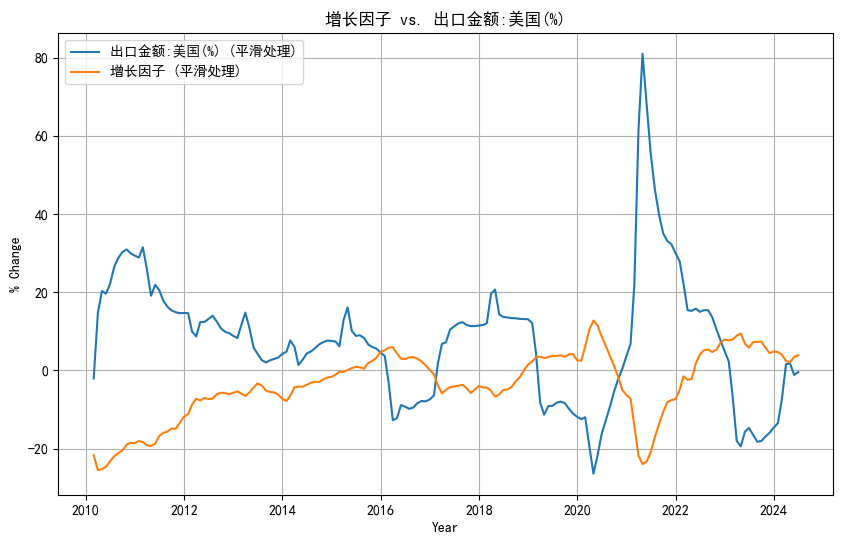

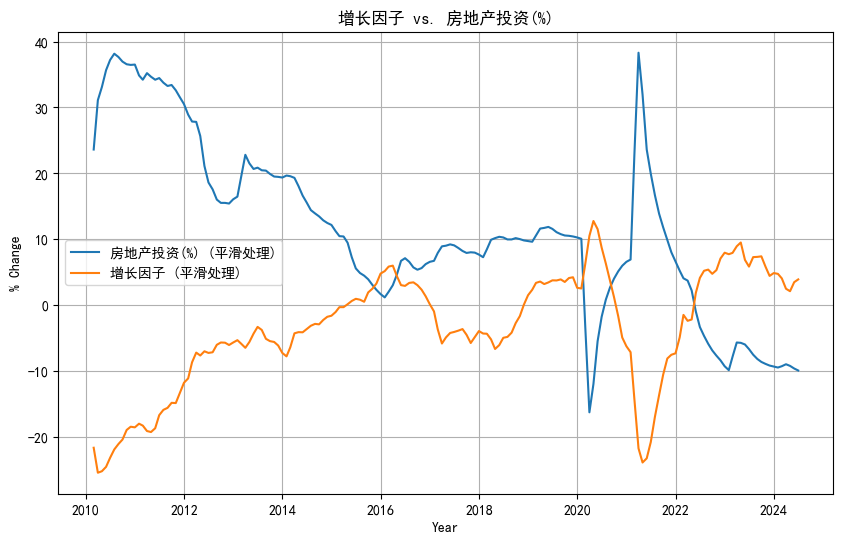

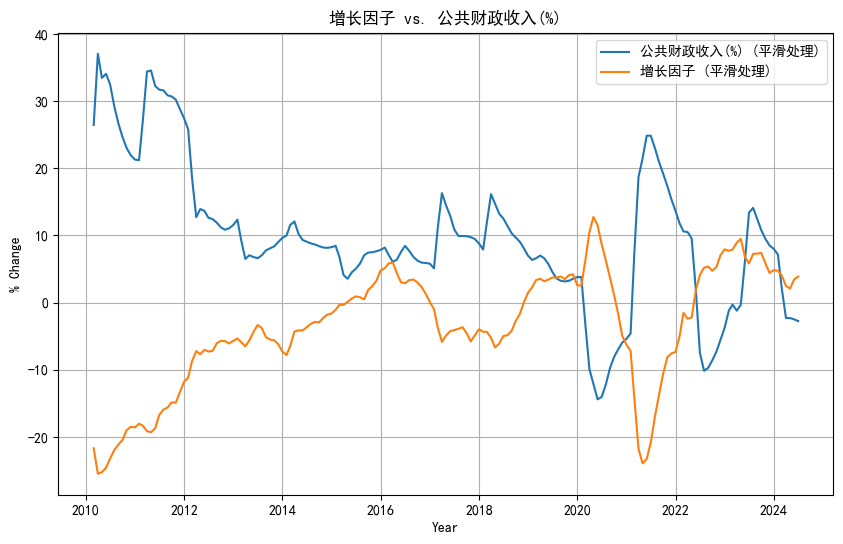

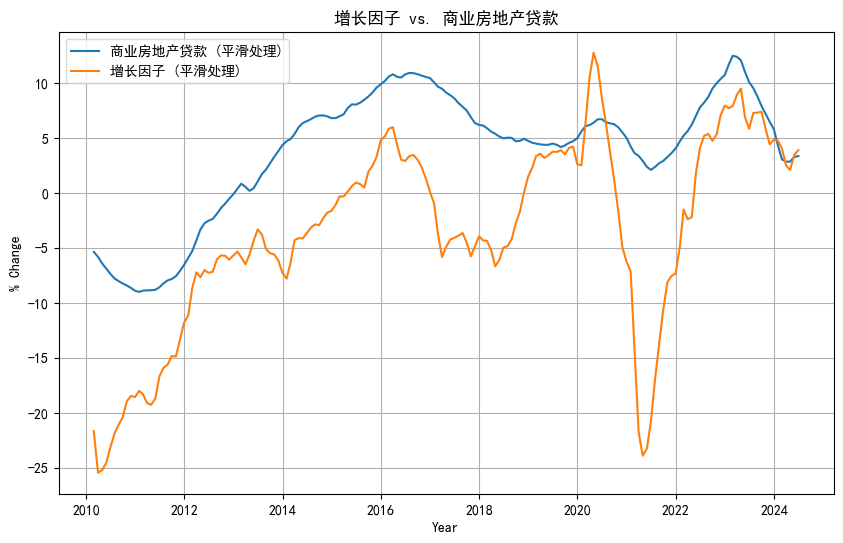

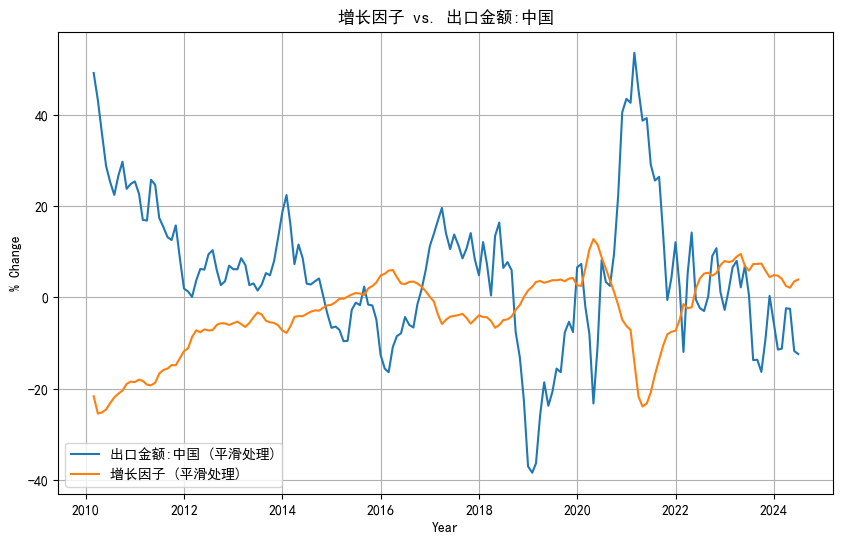

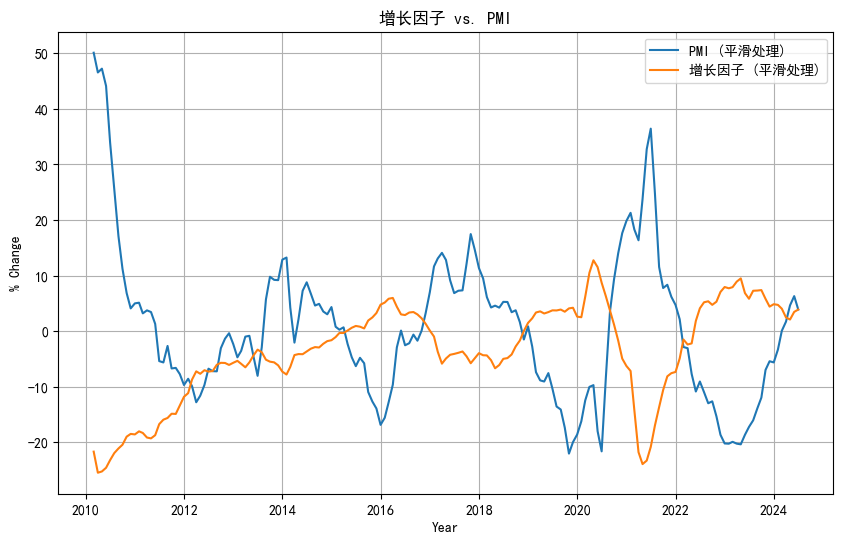

In [68]:
# 绘制图表
for cg in china_growth:
    plot_smoothed_data("增长", growth, df_china_growth, cg)
for usg in us_growth:
    plot_smoothed_data("增长", growth, df_us_growth, usg)


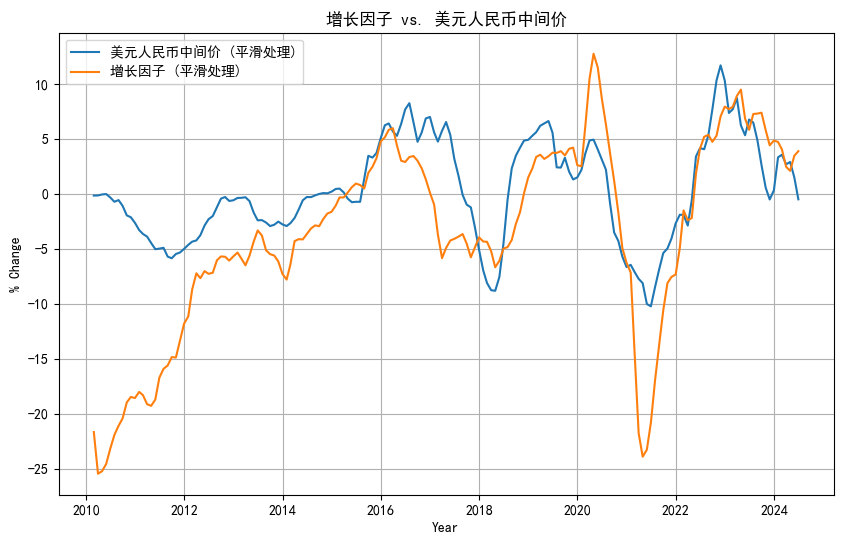

In [70]:
plot_smoothed_data("增长", growth, df_forex, "美元人民币中间价")

## Inflation Factor